In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

#params = {"font.size" : 16}
#plt.rcParams.update(params)
#plt.style.use('dark_background')

## Data Preparation

In [2]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## (Alternatively) Select only Halal lq45 tickers using issi tickers
halal_lq45_tickers = [f for f in lq45_tickers if f in issi_tickers]

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]
halal_active_tickers_international = [f + '.JK' for f in halal_lq45_tickers]

In [3]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 136.86it/s]


In [4]:
# Do Some basic data Operations (Fill NaN and calculate Returns)
for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Calculate Returns using Adjusted Close
    lq45_df_dict[ticker]['returns'] = lq45_df_dict[ticker]['Adj Close'].pct_change()
    
    # Drop earliest NaN Value without Returns
    lq45_df_dict[ticker].dropna(inplace=True)

# Do the same for lq45 index data
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data['returns'] = lq45_index_data['Adj Close'].pct_change()
lq45_index_data.dropna(inplace=True)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 298.36it/s]


In [5]:
# Select Data Range
lq45_index_data = lq45_index_data[lq45_index_data['Date'] >= '2012-01-01']
lq45_index_data = lq45_index_data.reset_index(drop=True)

## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [6]:
# Simple buy and hold strategy
lq45_index_buy_hold = lq45_index_data.copy()

lq45_index_buy_hold['signal'] = ''
lq45_index_buy_hold['close'] = lq45_index_buy_hold['Adj Close']
lq45_index_buy_hold = lq45_index_buy_hold[['Date', 'close', 'signal']]
lq45_index_buy_hold = lq45_index_buy_hold.reset_index(drop=True)

lq45_index_buy_hold['signal'][0] = 'buy'
lq45_index_buy_hold['signal'][len(lq45_index_buy_hold)-1] = 'sell'

### Implement Strategy
Source: https://mikeharrisny.medium.com/efficient-market-hypothesis-the-biggest-farce-in-history-of-finance-and-economics-3f69c8e0de45

Long only, buy signal is closed on sell signal.

In [7]:
# Define Strategy
def strategy(df):
    # Take only the important columns
    df_proc = df
    df_proc['signal'] = ''
    df_proc['close'] = df_proc['Adj Close']
    df_proc = df_proc[['Date', 'close', 'signal']]
    
    # Generate EMA
    df_proc.ta.ema(append=True)
    df_proc.dropna(inplace=True)
    df_proc = df_proc.reset_index(drop=True)
    
    # Signal Rule
    buy_signal = lambda price, ema: (price > ema)
    sell_signal = lambda price, ema: (price < ema)
    
    # Generate Signals
    last_signal = ''
    for i in tqdm(range(0, len(df_proc))):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if buy_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'buy'
                last_signal = 'buy'
            elif sell_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'sell'
                last_signal = 'sell'
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'buy':
            if sell_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'sell'
                last_signal = 'sell'
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'sell':
            if buy_signal(df_proc['close'][i], df_proc['EMA_10'][i]):
                df_proc['signal'][i] = 'buy'
                last_signal = 'buy'
            else:
                df_proc['signal'][i] = ''
    
    return df_proc

In [8]:
# Run Strategy
lq45_index_processed = strategy(lq45_index_data)

100%|█████████████████████████████████████████████████████████████| 2519/2519 [00:00<00:00, 3783.67it/s]


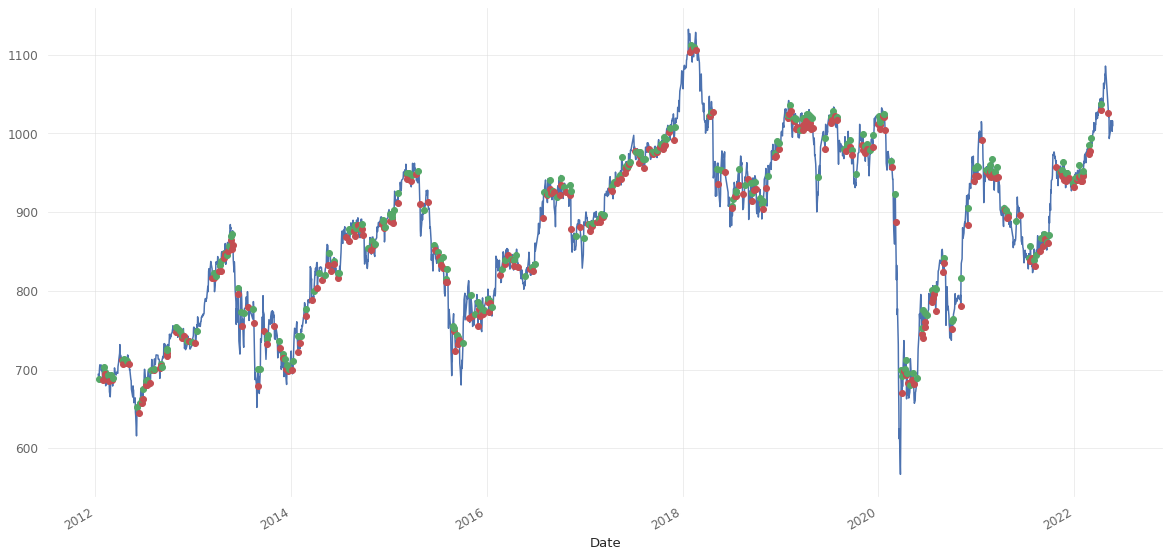

In [9]:
# Plot Buy and Sell Signals On Graph
lq45_index_processed['Date'] = pd.to_datetime(lq45_index_processed['Date'])
lq45_index_processed.set_index('Date')['close'].plot(figsize=(20,10), grid=True)

## Plot Buy and Sell Dots
for i in range(0, len(lq45_index_processed)):
    if lq45_index_processed['signal'][i] == 'buy':
        plt.plot(lq45_index_processed['Date'][i], lq45_index_processed['close'][i], 'go')
    elif lq45_index_processed['signal'][i] == 'sell':
        plt.plot(lq45_index_processed['Date'][i], lq45_index_processed['close'][i], 'ro')

### Calculate Returns and Metrics

In [10]:
# Define Returns and Metric Calculations

def calc_returns(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Is strategy specific.
    '''
    last_signal = ''
    df['return'] = ''
    for i in range(0, len(df)):
        if last_signal == 'buy':
            df["return"][i] = (df['close'][i] / df['close'][i-1]) - 1
        elif last_signal == 'sell':
            df["return"][i] = 0
        else:
            df["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df["signal"][i] 

    df["cum_return"] = (1 + df["return"]).cumprod()
    return df

def calc_cagr(df):
    '''
    Calculate the Cumulative Annual Growth Rate of a trading strategy
    '''
    n = len(df)/252
    cagr = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return cagr

def calc_volatility(df):
    "Calculate annualized volatility"
    vol = df["return"].std() * np.sqrt(252)
    return vol

def calc_sharpe(df, rf=0.025):
    '''
    Calculate annualized sharpe ratio
    rf: the risk free rate, default 2.5%
    '''
    sr = (calc_cagr(df) - rf)/calc_volatility(df)
    return sr

def max_drawdown(df):
    '''
    Calculate maximum drawdown and maximum drawdown length
    '''
    df_proc = df.copy()
    df_proc["cum_roll_max"] = df_proc["cum_return"].cummax()
    df_proc["drawdown"] = df_proc["cum_roll_max"] - df_proc["cum_return"]
    df_proc["drawdown_pct"] = df_proc["drawdown"]/df_proc["cum_roll_max"]
    
    max_dd = df_proc["drawdown_pct"].max()
    
    max_dd_len = {
                    'len': 0,
                    'start': 0,
                    'end': 0
                 }
    dd_len_counter = 0
    dd_start = 0
    for i in range(0, len(df_proc)):
        if df_proc["cum_return"][i] == df_proc["cum_roll_max"][i]:
            if dd_len_counter >= max_dd_len['len']:
                max_dd_len['len'] = dd_len_counter
                max_dd_len['start'] = dd_start
                max_dd_len['end'] = dd_start + dd_len_counter
                
            dd_len_counter = 0
            dd_start = i
        dd_len_counter += 1
    
    if dd_len_counter >= max_dd_len['len']:
        max_dd_len['len'] = dd_len_counter
        max_dd_len['start'] = dd_start
        max_dd_len['end'] = dd_start + dd_len_counter
            
    return max_dd, max_dd_len

#### Calculate Metrics for Strategy

In [31]:
# Calculate Metrics
eval_df = calc_returns(lq45_index_processed)
cagr = calc_cagr(eval_df)
volatility = calc_volatility(eval_df)
sr = calc_sharpe(eval_df)
max_dd, max_dd_len = max_drawdown(eval_df)

print('CAGR                : ' + str(cagr*100) + ' %')
print('Volatility          : ' + str(volatility*100) + ' %')
print('Sharpe Ratio        : ' + str(sr))
print('Max Drawdown        : ' + str(max_dd*100) + ' %')
print('Max Drawdown Length : ' + str(max_dd_len['len']) + ' days')
print('Max Drawdown Start  : Index ' + str(max_dd_len['start'])) # add datetime
print('Max Drawdown End    : Index ' + str(max_dd_len['end']))

CAGR                : -3.66927706661927 %
Volatility          : 13.360223474227428 %
Sharpe Ratio        : -0.4617645115383084
Max Drawdown        : 40.58911618312162 %
Max Drawdown Length : 2188 days
Max Drawdown Start  : Index 331
Max Drawdown End    : Index 2519


<AxesSubplot:xlabel='Date'>

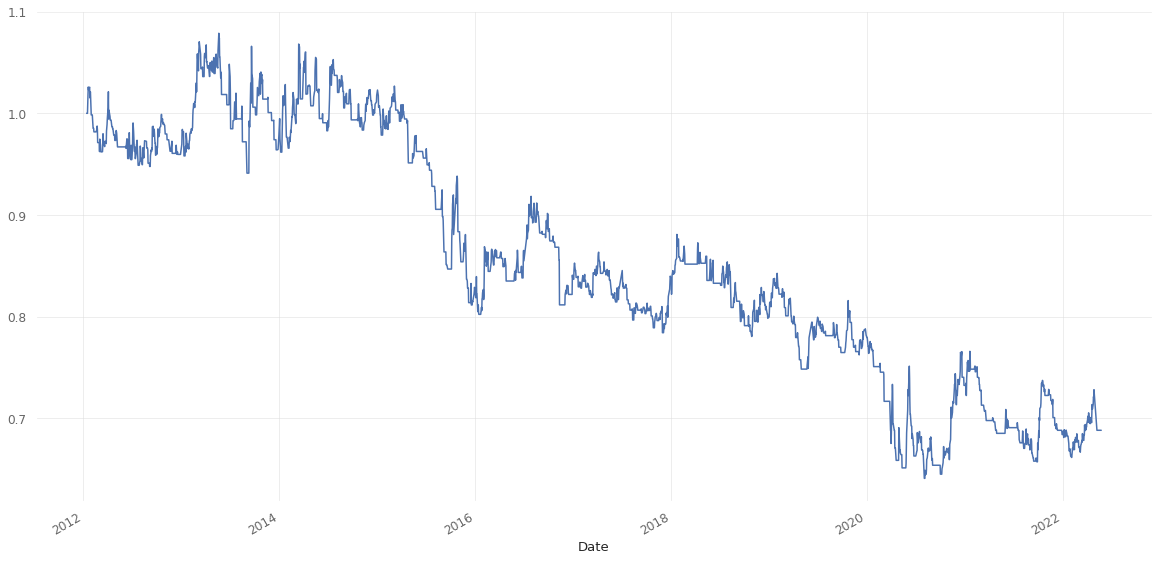

In [33]:
# Plot Cumulative Returns
eval_df.set_index('Date')['cum_return'].plot(figsize=(20,10), grid=True)

#### Calculate Metrics for LQ45 Buy and Hold

In [34]:
# Calculate Metrics
eval_df = calc_returns(lq45_index_buy_hold)
cagr = calc_cagr(eval_df)
volatility = calc_volatility(eval_df)
sr = calc_sharpe(eval_df)
max_dd, max_dd_len = max_drawdown(eval_df)

print('CAGR                : ' + str(cagr*100) + ' %')
print('Volatility          : ' + str(volatility*100) + ' %')
print('Sharpe Ratio        : ' + str(sr))
print('Max Drawdown        : ' + str(max_dd*100) + ' %')
print('Max Drawdown Length : ' + str(max_dd_len['len']) + ' days')
print('Max Drawdown Start  : Index ' + str(max_dd_len['start']))
print('Max Drawdown End    : Index ' + str(max_dd_len['end']))

CAGR                : 4.158593317167969 %
Volatility          : 21.05024197956465 %
Sharpe Ratio        : 0.07879212594221546
Max Drawdown        : 49.93507746714257 %
Max Drawdown Length : 1051 days
Max Drawdown Start  : Index 1477
Max Drawdown End    : Index 2528


<AxesSubplot:xlabel='Date'>

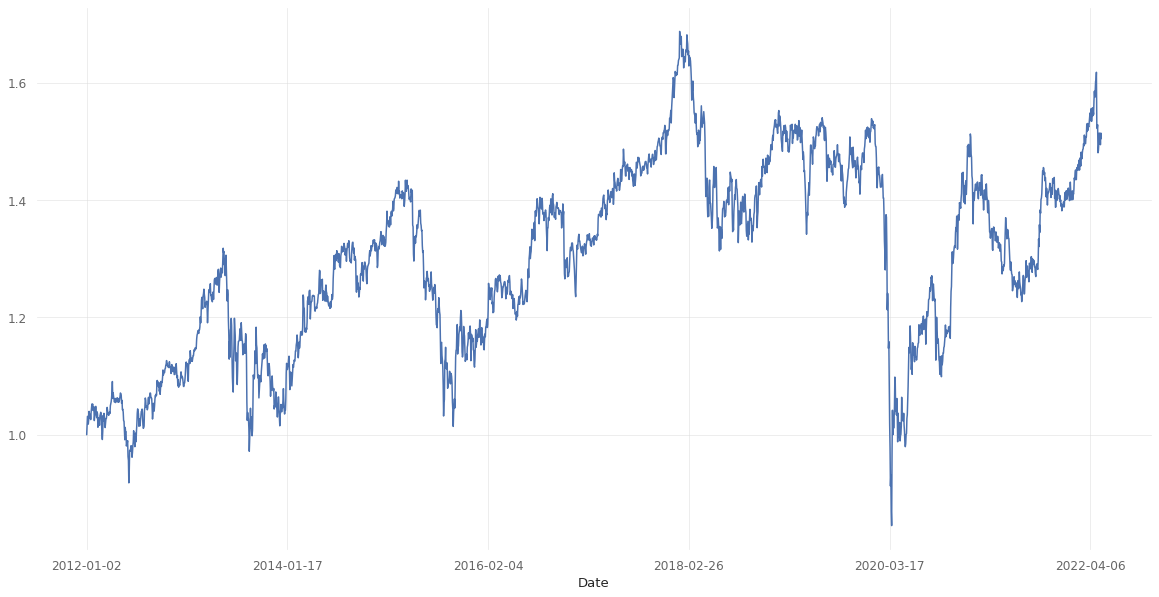

In [35]:
# Plot Cumulative Returns
eval_df.set_index('Date')['cum_return'].plot(figsize=(20,10), grid=True)